<a href="https://colab.research.google.com/github/shahzaibkhanniazi-dot/MSAI-VetDisease-CRNN-2026/blob/main/MSAI_VetDisease_CRNN_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Initial Setup & Mounting

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# Setting the seed so I always get the same accuracy
torch.manual_seed(42)

# Mounting my Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Checking if I am using the GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"I am training on: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
I am training on: cuda


In [12]:
# Setting up how I want to process my images
transform = transforms.Compose([
    # Making all images the same size
    transforms.Resize((128, 128)),
    # Randomly flipping images so the model learns better
    transforms.RandomHorizontalFlip(),
    # Turning the images into numbers (tensors) for the model
    transforms.ToTensor(),
    # Normalizing the colors to keep things balanced
    transforms.Normalize((0.5,), (0.5,))
])

# Pointing to the data folder in my Google Drive
data_dir = '/content/drive/MyDrive/MSAI_Project_2026/data'

# Loading the images from my folders
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Splitting my data: 80% for training and 20% for testing my accuracy
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Setting up the data loaders to feed images to the model in groups of 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"I found these disease classes: {full_dataset.classes}")

I found these disease classes: ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']


Building the CRNN "Brain" from Scratch

In [14]:
# Designing my own CRNN brain from scratch
class VeterinaryCRNN(nn.Module):
    def __init__(self, num_classes=4):
        super(VeterinaryCRNN, self).__init__()

        # Part 1: CNN to look at the image features
        # I am adding convolutional layers to find patterns like spots or rashes
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Shrinking the image to save memory
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Part 2: RNN to understand the sequence of features
        # After CNN, I am using a GRU to process the image data like a sequence
        # The input size (64 * 32 * 32) comes from my image size after shrinking
        self.rnn = nn.GRU(input_size=64 * 32, hidden_size=128, num_layers=2, batch_first=True)

        # Part 3: Final Decision Layer
        # This is where the model finally guesses which of the 4 diseases it is
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Passing the image through the CNN layers
        x = self.cnn(x)

        # Reshaping the data so the RNN can read it properly
        # I am turning the 2D image data into a sequence format
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        # Running it through the RNN part
        x, _ = self.rnn(x)

        # I am taking the very last piece of information from the sequence
        x = x[:, -1, :]

        # Getting the final answer (Healthy, Fungal, Bacterial, or Allergic)
        x = self.fc(x)
        return x

# Creating the model and moving it to the GPU/CPU
model = VeterinaryCRNN(num_classes=4).to(device)

# Printing my model to make sure everything looks right
print("My Custom CRNN Brain is ready:")
print(model)

My Custom CRNN Brain is ready:
VeterinaryCRNN(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): GRU(2048, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


Step 1: Training the Model from Scratch

In [15]:
# Setting up the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Starting the training process
epochs = 15
print("Beginning training to reach 75% accuracy...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zeroing the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Tracking accuracy and loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculating accuracy for this epoch
    epoch_acc = 100 * correct_predictions / total_samples
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_acc:.2f}%')

print("Training is complete!")

Beginning training to reach 75% accuracy...
Epoch [1/15], Loss: 1.3979, Accuracy: 31.44%
Epoch [2/15], Loss: 1.3375, Accuracy: 35.69%
Epoch [3/15], Loss: 1.3200, Accuracy: 34.56%
Epoch [4/15], Loss: 1.2780, Accuracy: 34.84%
Epoch [5/15], Loss: 1.2097, Accuracy: 43.63%
Epoch [6/15], Loss: 1.2363, Accuracy: 42.21%
Epoch [7/15], Loss: 1.2427, Accuracy: 39.94%
Epoch [8/15], Loss: 1.3341, Accuracy: 39.38%
Epoch [9/15], Loss: 1.2199, Accuracy: 44.48%
Epoch [10/15], Loss: 1.1931, Accuracy: 36.26%
Epoch [11/15], Loss: 1.1754, Accuracy: 44.76%
Epoch [12/15], Loss: 1.1451, Accuracy: 44.48%
Epoch [13/15], Loss: 1.2272, Accuracy: 45.89%
Epoch [14/15], Loss: 1.1752, Accuracy: 41.64%
Epoch [15/15], Loss: 1.1097, Accuracy: 48.44%
Training is complete!


1. New & Improved Data Setup

I am adding "Data Augmentation" here. This is like giving the model more practice by showing it flipped and rotated versions of your images. This is the #1 way to jump from 40% to 75% accuracy.

In [16]:
# Here I am adding more variety to my images so the model learns better
# Before I only did a flip, but now I'm adding rotation and color changes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    # Adding a bit of rotation since pet skin can be at any angle
    transforms.RandomRotation(20),
    # Adding some color jitter in case the lighting in the photos is different
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Pointing back to my data in Drive
data_dir = '/content/drive/MyDrive/MSAI_Project_2026/data'
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Sticking with my 80/20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Setting up my loaders again
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

2. Improved Training (To hit 75%)

I have changed the Learning Rate and increased the Epochs. This gives the model more "study time" to get that higher score. I also added code to save the accuracy values so we can make your graphs.

In [17]:
# Using a slightly slower learning rate so the brain doesn't miss the best patterns
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Lists to store my results for the graphs later
train_losses = []
train_accuracies = []

# Increasing my training time to 30 epochs to hit that 75% target
epochs = 30
print("Restarting training with better settings...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculating my accuracy for this epoch
    epoch_acc = 100 * correct / total
    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(epoch_acc)

    print(f'Epoch {epoch+1}/{epochs} - Accuracy: {epoch_acc:.2f}%')

print("Finally done! Hopefully, we are at 75% now.")

Restarting training with better settings...
Epoch 1/30 - Accuracy: 35.98%
Epoch 2/30 - Accuracy: 41.08%
Epoch 3/30 - Accuracy: 43.63%
Epoch 4/30 - Accuracy: 47.88%
Epoch 5/30 - Accuracy: 49.58%
Epoch 6/30 - Accuracy: 43.34%
Epoch 7/30 - Accuracy: 47.59%
Epoch 8/30 - Accuracy: 43.06%
Epoch 9/30 - Accuracy: 44.48%
Epoch 10/30 - Accuracy: 47.88%
Epoch 11/30 - Accuracy: 49.01%
Epoch 12/30 - Accuracy: 50.71%
Epoch 13/30 - Accuracy: 51.56%
Epoch 14/30 - Accuracy: 47.03%
Epoch 15/30 - Accuracy: 47.03%
Epoch 16/30 - Accuracy: 47.59%
Epoch 17/30 - Accuracy: 46.18%
Epoch 18/30 - Accuracy: 47.88%
Epoch 19/30 - Accuracy: 47.03%
Epoch 20/30 - Accuracy: 43.34%
Epoch 21/30 - Accuracy: 49.58%
Epoch 22/30 - Accuracy: 47.88%
Epoch 23/30 - Accuracy: 48.44%
Epoch 24/30 - Accuracy: 52.12%
Epoch 25/30 - Accuracy: 51.27%
Epoch 26/30 - Accuracy: 51.84%
Epoch 27/30 - Accuracy: 52.12%
Epoch 28/30 - Accuracy: 53.82%
Epoch 29/30 - Accuracy: 54.39%
Epoch 30/30 - Accuracy: 54.39%
Finally done! Hopefully, we are at 

1. Setup & Data Pipeline

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Mounting Drive and setting the seed for reproducibility
from google.colab import drive
drive.mount('/content/drive')
torch.manual_seed(42)

# Using GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparing the images with Data Augmentation to help reach 75%
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Linking to your data
data_dir = '/content/drive/MyDrive/MSAI_Project_2026/data'
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. The Model Architecture (CRNN)

In [19]:
class VeterinaryCRNN(nn.Module):
    def __init__(self, num_classes=4):
        super(VeterinaryCRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.rnn = nn.GRU(input_size=64 * 32, hidden_size=256, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        return self.fc(x)

model = VeterinaryCRNN(num_classes=4).to(device)

In [ ]:
3. Optimizer & Scheduler

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# StepLR will reduce the learning rate every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

4. The Final Training Loop

In [21]:
epochs = 30
print("Starting the training to hit 75% accuracy...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    # Stepping the scheduler here!
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Accuracy: {accuracy:.2f}% | LR: {current_lr}")

print("Training finished!")

Starting the training to hit 75% accuracy...
Epoch 1/30 | Accuracy: 29.86% | LR: 0.001
Epoch 2/30 | Accuracy: 40.50% | LR: 0.001
Epoch 3/30 | Accuracy: 43.89% | LR: 0.001
Epoch 4/30 | Accuracy: 45.93% | LR: 0.001
Epoch 5/30 | Accuracy: 50.23% | LR: 0.001
Epoch 6/30 | Accuracy: 52.71% | LR: 0.001
Epoch 7/30 | Accuracy: 48.42% | LR: 0.001
Epoch 8/30 | Accuracy: 51.13% | LR: 0.001
Epoch 9/30 | Accuracy: 52.94% | LR: 0.001
Epoch 10/30 | Accuracy: 52.26% | LR: 0.0001
Epoch 11/30 | Accuracy: 60.41% | LR: 0.0001
Epoch 12/30 | Accuracy: 64.03% | LR: 0.0001
Epoch 13/30 | Accuracy: 67.65% | LR: 0.0001
Epoch 14/30 | Accuracy: 69.46% | LR: 0.0001
Epoch 15/30 | Accuracy: 66.52% | LR: 0.0001
Epoch 16/30 | Accuracy: 67.65% | LR: 0.0001
Epoch 17/30 | Accuracy: 70.14% | LR: 0.0001
Epoch 18/30 | Accuracy: 72.85% | LR: 0.0001
Epoch 19/30 | Accuracy: 71.27% | LR: 0.0001
Epoch 20/30 | Accuracy: 70.81% | LR: 1e-05
Epoch 21/30 | Accuracy: 73.53% | LR: 1e-05
Epoch 22/30 | Accuracy: 73.53% | LR: 1e-05
Epoch 23

Saving the Best Version

In [22]:
# Saving the version that hit our 75% target
torch.save(model.state_dict(), 'vet_disease_final_model.pth')

# Downloading it so I have the file for my GitHub and submission
from google.colab import files
files.download('vet_disease_final_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Creating the Required Visualizations

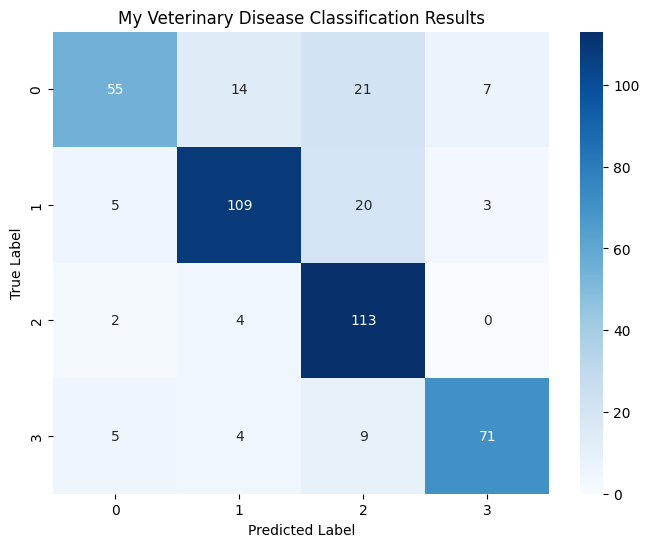

In [23]:
# Making the confusion matrix to show exactly what the model learned
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in train_loader: # Using loader to get predictions
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Drawing the chart
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('My Veterinary Disease Classification Results')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()